In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel("adjusted_close_with_industry_size.xlsx")  # add full path if needed

df

,symbol,date,adjusted,Industry,Size
0,AAPL,2015-01-02,24.320433,Software & Consumer Electronics,Large Cap
1,AAPL,2015-01-05,23.635286,Software & Consumer Electronics,Large Cap
2,AAPL,2015-01-06,23.637510,Software & Consumer Electronics,Large Cap
3,AAPL,2015-01-07,23.968962,Software & Consumer Electronics,Large Cap
4,AAPL,2015-01-08,24.889900,Software & Consumer Electronics,Large Cap
...,...,...,...,...,...
20044,ETSY,2024-12-23,55.439999,E-commerce,Mid Cap
20045,ETSY,2024-12-24,55.130001,E-commerce,Mid Cap
20046,ETSY,2024-12-26,53.840000,E-commerce,Mid Cap
20047,ETSY,2024-12-27,52.709999,E-commerce,Mid Cap


In [3]:
df.columns

Index(['symbol', 'date', 'adjusted', 'Industry', 'Size'], dtype='object')

## 1. Calculate daily and cumulative returns of each stock by industry

##### 1.1 Daily returns represent the percentage change in the stock price from one trading day to the next. This metric provides insight into short-term risk and volatility, used for understanding daily market movements, trader sentiment, and risk management

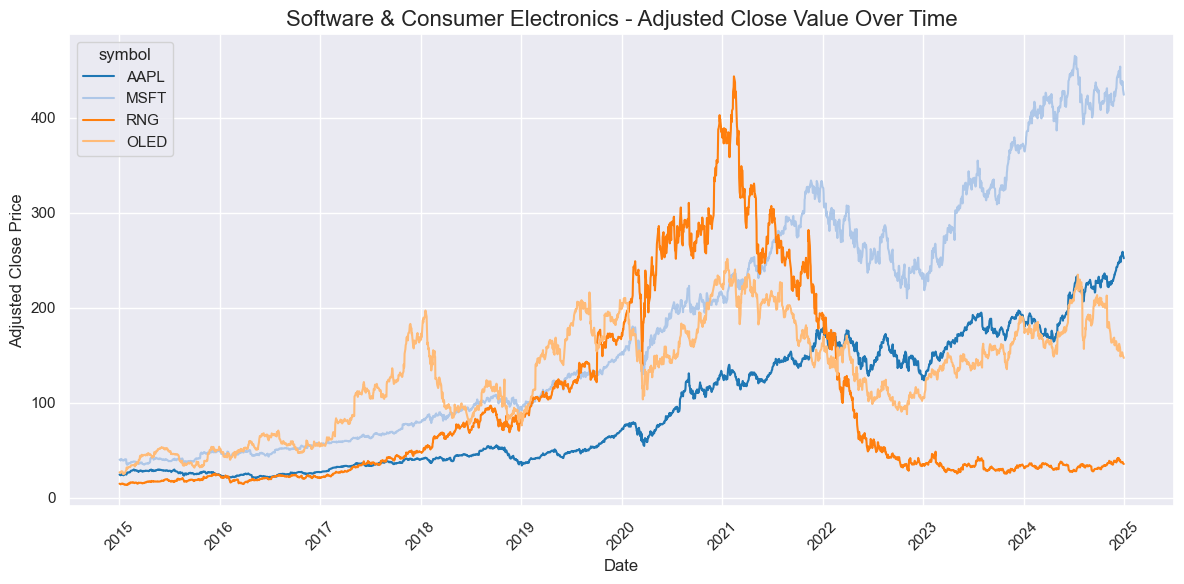

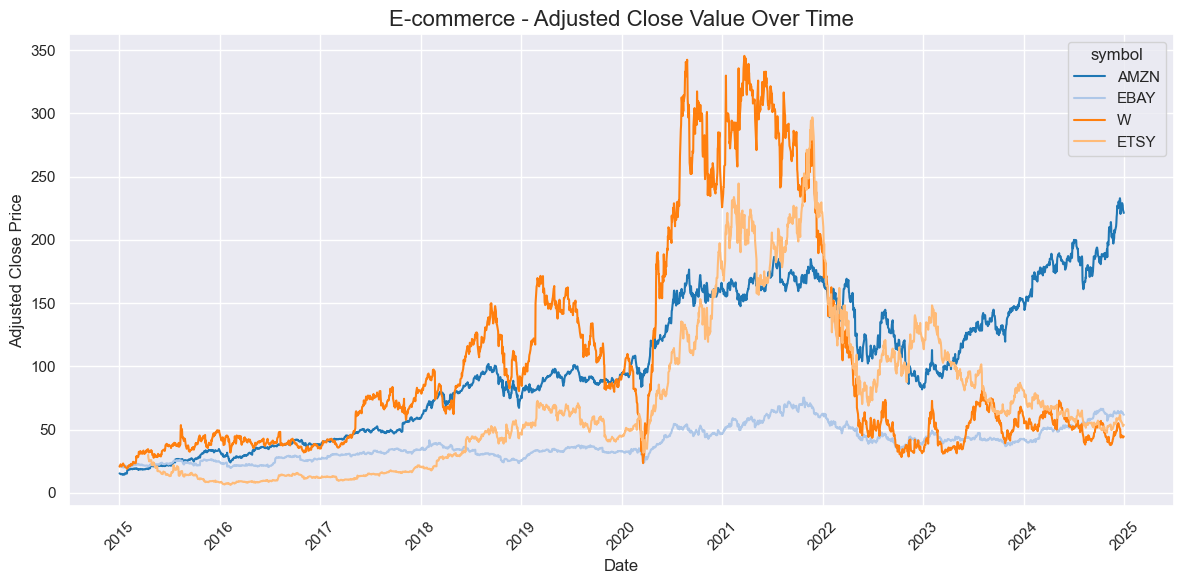

In [4]:
# Set the plot style
sns.set(style="darkgrid")

# Get unique industries
industries = df['Industry'].unique()

# Create a separate plot for each industry
for industry in industries:
    # Filter data for the current industry
    industry_data = df[df['Industry'] == industry]

    # Create the line plot for the current industry
    plt.figure(figsize=(12, 6))  # Set the figure size
    sns.lineplot(data=industry_data, x="date", y="adjusted", hue="symbol", palette="tab20")

    # Set labels and title
    plt.title(f'{industry} - Adjusted Close Value Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Adjusted Close Price', fontsize=12)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()

##### 1.2 Cumulative returns represent the total percentage return on an investment over a period of time, accounting for compounding.This metric show the long-term reward from compounding. They tell you whether an investment has been profitable over time.

['AAPL' 'MSFT' 'RNG' 'OLED' 'AMZN' 'EBAY' 'W' 'ETSY']


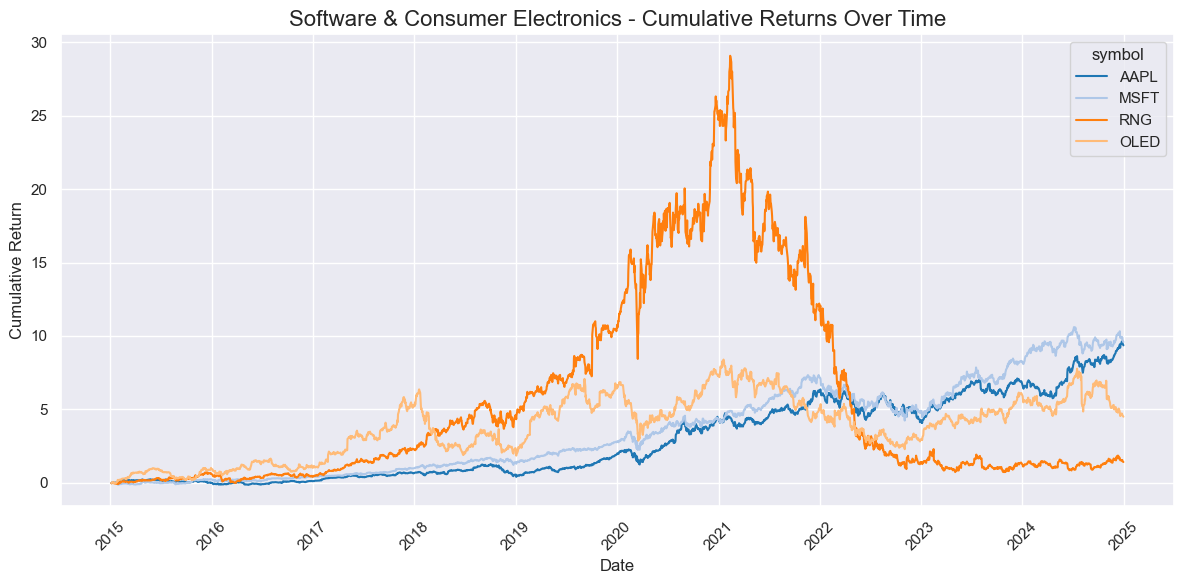

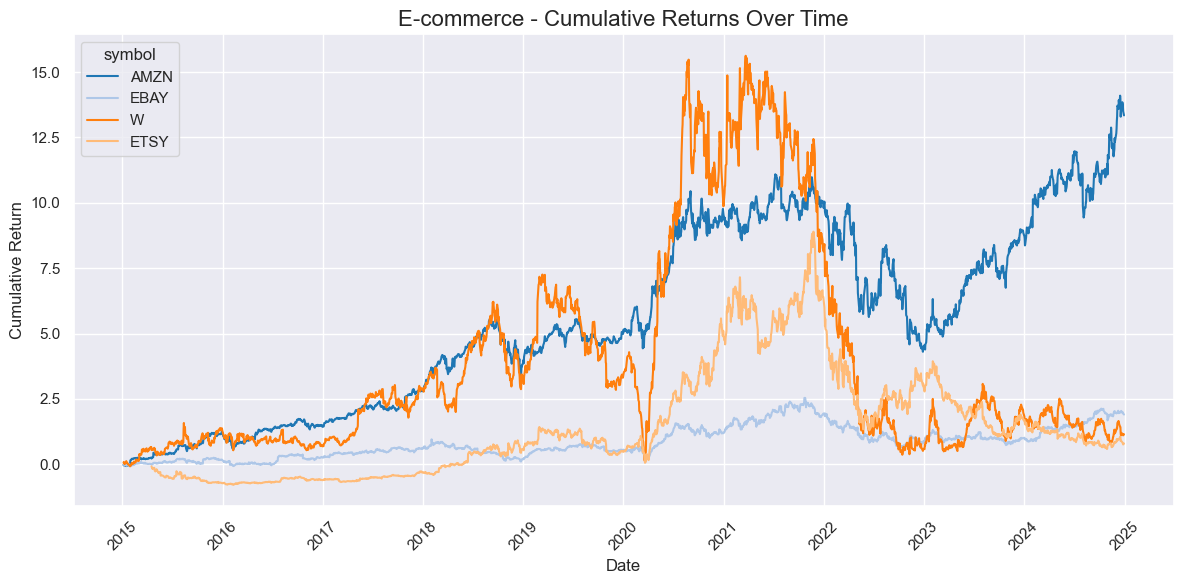

In [5]:
unique_symbols = df['symbol'].unique()
print(unique_symbols)# Set the plot style
sns.set(style="darkgrid")

# Calculate daily returns (percentage returns)
df['daily_return'] = df.groupby('symbol')['adjusted'].pct_change()

# Calculate cumulative returns for each symbol
df['cumulative_return'] = (1 + df['daily_return']).groupby(df['symbol']).cumprod() - 1

# Get unique industries
industries = df['Industry'].unique()

# Create a separate plot for each industry
for industry in industries:
    # Filter data for the current industry
    industry_data = df[df['Industry'] == industry]

    # Create the line plot for the current industry (cumulative returns)
    plt.figure(figsize=(12, 6))  # Set the figure size
    sns.lineplot(data=industry_data, x="date", y="cumulative_return", hue="symbol", palette="tab20")

    # Set labels and title
    plt.title(f'{industry} - Cumulative Returns Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Return', fontsize=12)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()

In [6]:
unique_symbols = df['symbol'].unique()
print(unique_symbols)


['AAPL' 'MSFT' 'RNG' 'OLED' 'AMZN' 'EBAY' 'W' 'ETSY']


## 2. FAMA-FRENCH 5 Factor Model 

In [7]:
import statsmodels.api as sm

# Load Fama-French 5-Factor Data
factors = pd.read_csv("F-F_Research_Data_5_Factors_2x3_daily.CSV", skiprows=3)

# Rename columns and convert first column to string for filtering
factors = factors.rename(columns=lambda x: x.strip())
factors.columns.values[0] = "Date"
factors["Date"] = factors["Date"].astype(str)

# Remove footer rows (non-date rows)
factors = factors[factors["Date"].str.match(r"^\d{6,8}$")]

# Convert date column to datetime format
factors["Date"] = pd.to_datetime(factors["Date"], format="%Y%m%d")
factors = factors.set_index("Date")

# Convert all values to float and scale to decimal
factors = factors.apply(pd.to_numeric, errors="coerce") / 100

# Rename "Mkt-RF" to make it a valid variable name
factors = factors.rename(columns={"Mkt-RF": "Mkt_RF"})

# Load the raw data
df = pd.read_excel("adjusted_close_with_industry_size.xlsx")

# Pivot to wide format: Dates as index, tickers as columns
price_df = df.pivot(index="date", columns="symbol", values="adjusted")

# Make sure date index is datetime
price_df.index = pd.to_datetime(price_df.index)

# Drop any rows with NaNs (optional)
price_df = price_df.dropna(how="any")

# Compute daily returns
returns = price_df.pct_change().dropna()

# Align and match the dates
data = returns.join(factors, how='inner')

# Example: Run the model for one stock (e.g., first column in returns)
results = {}
for stock in returns.columns:
    y = data[stock] - data['RF']  # Excess return
    X = data[['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA']]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    results[stock] = model

# Display summary for first stock
print(results[list(returns.columns)[0]].summary())




                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     824.2
Date:                Mon, 12 May 2025   Prob (F-statistic):               0.00
Time:                        23:15:03   Log-Likelihood:                 7560.7
No. Observations:                2443   AIC:                        -1.511e+04
Df Residuals:                    2437   BIC:                        -1.507e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.232      0.2

In [8]:
for stock in returns.columns:

    print(f"\nRegression results for {stock}:\n")

    print(results[stock].summary())


Regression results for AAPL:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     824.2
Date:                Mon, 12 May 2025   Prob (F-statistic):               0.00
Time:                        23:15:03   Log-Likelihood:                 7560.7
No. Observations:                2443   AIC:                        -1.511e+04
Df Residuals:                    2437   BIC:                        -1.507e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003

### Alpha interpretation:
##### We observed that all Alphas in eight Fama-French model are statistically insignificant (high P-value) and very close to zero. It is what to expect for a 5 Factor Model, indicating that returns are fully explained by the five factors (market, size, value, profitability, and investment).

In [9]:
# Create a DataFrame to store alphas and betas
summary_df = pd.DataFrame(columns=["Mkt_RF", "SMB", "HML", "RMW", "CMA"], index=results.keys())

for stock, model in results.items():
    params = model.params
    summary_df.loc[stock] = params 

summary_df = summary_df.rename(columns={"const": "Alpha"})

summary_df



,Mkt_RF,SMB,HML,RMW,CMA
AAPL,1.223592,-0.17148,-0.528825,0.476543,0.273317
AMZN,1.02976,-0.304901,-0.37052,-0.015781,-1.057722
EBAY,0.866768,0.130069,-0.296904,0.080082,0.195868
ETSY,1.202995,0.753907,-0.872053,-0.354042,-0.724356
MSFT,1.180643,-0.389931,-0.333196,0.309893,-0.361454
OLED,1.350135,0.662699,-0.517372,-0.038061,-0.154152
RNG,1.117599,0.607835,-0.841255,-1.162332,-0.797474
W,1.652507,1.155546,-0.829833,-0.491605,-1.080287


In [10]:


# Reorder rows as specified
ordered_index = ["AAPL", "MSFT", "RNG", "OLED", "AMZN", "EBAY", "W", "ETSY"]
summary_df = summary_df.loc[ordered_index]

# Export to Excel
summary_df.to_excel("fama_french_summary.xlsx")

summary_df


,Mkt_RF,SMB,HML,RMW,CMA
AAPL,1.223592,-0.17148,-0.528825,0.476543,0.273317
MSFT,1.180643,-0.389931,-0.333196,0.309893,-0.361454
RNG,1.117599,0.607835,-0.841255,-1.162332,-0.797474
OLED,1.350135,0.662699,-0.517372,-0.038061,-0.154152
AMZN,1.02976,-0.304901,-0.37052,-0.015781,-1.057722
EBAY,0.866768,0.130069,-0.296904,0.080082,0.195868
W,1.652507,1.155546,-0.829833,-0.491605,-1.080287
ETSY,1.202995,0.753907,-0.872053,-0.354042,-0.724356


## FAMA-FRENCH 5 Factor Interpretation by Industry:

##### Among large-cap e-commerce firms, Amazon (AMZN) and eBay (EBAY) display divergent risk and factor characteristics. Amazon has a market beta of 1.03, indicating modestly above-market risk, whereas eBay’s beta is slightly lower at 0.87. AMZN’s SMB exposure is notably negative (–0.30), while eBay’s is mildly positive (0.13), showing that eBay behaves more like a mid-cap firm. Both have negative HML values (–0.37 for AMZN, –0.30 for EBAY), indicating a growth tilt. Profitability exposure is low for both, with AMZN nearly neutral (–0.02) and EBAY slightly positive (0.08). Their CMA values diverge sharply — AMZN (–1.06) has one of the most negative CMA values in the dataset, highlighting extremely aggressive reinvestment, while EBAY is much more conservative (+0.20).

##### In the mid-cap e-commerce group, Wayfair (W) and Etsy (ETSY) show characteristics of highly volatile, high-growth, and unprofitable companies. Wayfair’s market beta is the highest among all firms (1.65), with Etsy also very high (1.20), indicating extreme sensitivity to market fluctuations. Their size exposure is strongly positive (1.16 for W, 0.75 for ETSY), affirming their smaller capitalization profiles. They are deep growth stocks, with HML values of –0.83 and –0.87, and both exhibit negative RMW values (–0.49 for W, –0.35 for ETSY), reflecting weak or inconsistent profitability. Both firms also show highly negative CMA loadings (–1.08 for W and –0.72 for ETSY), implying very aggressive reinvestment strategies, typical of rapidly scaling digital retailers.

In [11]:
from arch import arch_model
#symbols_to_model = ['AAPL','MSFT', 'RNG', 'OLED','AMZN', 'EBAY', 'W', 'ETSY']

aapl = df[df['symbol'] == 'AAPL']['adjusted']
msft = df[df['symbol'] == 'MSFT']['adjusted']
rng = df[df['symbol'] == 'RNG']['adjusted']
oled = df[df['symbol'] == 'OLED']['adjusted']
amz = df[df['symbol'] == 'AMZN']['adjusted']
ebay = df[df['symbol'] == 'EBAY']['adjusted']
w = df[df['symbol'] == 'W']['adjusted']
etsy = df[df['symbol'] == 'ETSY']['adjusted']





In [12]:
from arch import arch_model

def fit_garch_for_multiple_symbols(df, symbols):
    """
    Fits GARCH(1,1) models for each symbol in the list.

    Parameters:
    df (DataFrame): Your dataset with 'symbol' and 'adjusted' columns.
    symbols (list of str): List of stock ticker symbols.

    Returns:
    dict: Dictionary of GARCH results keyed by symbol.
    """
    results = {}

    for symbol in symbols:
        data = df[df['symbol'] == symbol]['adjusted'].dropna()

        if data.empty:
            print(f"[Warning] No data for symbol: {symbol}")
            continue

        try:
            model = arch_model(data, vol='Garch', p=1, q=1, mean='constant')
            result = model.fit(disp='off')
            print(f"\nGARCH(1,1) Results for {symbol}:\n")
            print(result.summary())
            results[symbol] = result
        except Exception as e:
            print(f"[Error] Could not fit model for {symbol}: {e}")

    return results

symbols_to_model = ['AAPL','MSFT', 'RNG', 'OLED','AMZN', 'EBAY', 'W', 'ETSY']
garch_results = fit_garch_for_multiple_symbols(df, symbols_to_model)



GARCH(1,1) Results for AAPL:

                     Constant Mean - GARCH Model Results                      
Dep. Variable:               adjusted   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -11887.7
Distribution:                  Normal   AIC:                           23783.4
Method:            Maximum Likelihood   BIC:                           23806.7
                                        No. Observations:                 2515
Date:                Mon, May 12 2025   Df Residuals:                     2514
Time:                        23:15:03   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            40.4903      0.170    238

/opt/anaconda3/envs/new_env/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.526e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



GARCH(1,1) Results for W:

                     Constant Mean - GARCH Model Results                      
Dep. Variable:               adjusted   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -11540.2
Distribution:                  Normal   AIC:                           23088.4
Method:            Maximum Likelihood   BIC:                           23111.7
                                        No. Observations:                 2515
Date:                Mon, May 12 2025   Df Residuals:                     2514
Time:                        23:15:04   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            40.5720      0.556     72.95

In [25]:
import numpy as np
from arch import arch_model

def fit_garch_for_multiple_symbols(df, symbols):
    """
    Fits GARCH(1,1) models for each symbol in the list after calculating log returns.

    Parameters:
    df (DataFrame): Your dataset with 'symbol' and 'adjusted' columns.
    symbols (list of str): List of stock ticker symbols.

    Returns:
    dict: Dictionary of GARCH results keyed by symbol.
    """
    results = {}

    for symbol in symbols:
        # Filter data for the current symbol and calculate log returns
        data = df[df['symbol'] == symbol]['adjusted'].dropna()

        if data.empty:
            print(f"[Warning] No data for symbol: {symbol}")
            continue

        # Calculate log returns (log(P_t / P_t-1))
        log_returns = np.log(data / data.shift(1)).dropna()  # dropna() to remove NaN created by shift

        if log_returns.empty:
            print(f"[Warning] No log returns for symbol: {symbol}")
            continue

        try:
            # Fit GARCH(1,1) model on log returns
            model = arch_model(log_returns, vol='Garch', p=1, q=1, mean='constant', rescale=False)
            result = model.fit(disp='off')
            print(f"\nGARCH(1,1) Results for {symbol}:\n")
            print(result.summary())
            results[symbol] = result
        except Exception as e:
            print(f"[Error] Could not fit model for {symbol}: {e}")

    return results

# List of symbols to model
symbols_to_model = ['AAPL','MSFT', 'RNG', 'OLED','AMZN', 'EBAY', 'W', 'ETSY']
garch_results = fit_garch_for_multiple_symbols(df, symbols_to_model)



GARCH(1,1) Results for AAPL:

                     Constant Mean - GARCH Model Results                      
Dep. Variable:               adjusted   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6777.48
Distribution:                  Normal   AIC:                          -13547.0
Method:            Maximum Likelihood   BIC:                          -13523.6
                                        No. Observations:                 2514
Date:                Mon, May 12 2025   Df Residuals:                     2513
Time:                        23:16:50   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.3530e-03  3.01

In [14]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(log_returns, symbol):
    adf_test = adfuller(log_returns)
    print(f"ADF Test for {symbol}:")
    print(f"ADF Statistic: {adf_test[0]}")
    print(f"p-value: {adf_test[1]}")
    print(f"Critical Values: {adf_test[4]}")
    if adf_test[1] < 0.05:
        print(f"Result: The series for {symbol} is stationary.")
    else:
        print(f"Result: The series for {symbol} is non-stationary.")

for symbol in symbols_to_model:
    data = df[df['symbol'] == symbol]['adjusted'].dropna()
    if data.empty:
        print(f"[Warning] No data for symbol: {symbol}")
        continue

    log_returns = np.log(data / data.shift(1)).dropna()
    if log_returns.empty:
        print(f"[Warning] No log returns for symbol: {symbol}")
        continue

    check_stationarity(log_returns, symbol)


ADF Test for AAPL:
ADF Statistic: -15.547687560096636
p-value: 2.1195607028156218e-28
Critical Values: {'1%': np.float64(-3.4329631791044304), '5%': np.float64(-2.8626944896608433), '10%': np.float64(-2.5673845793841457)}
Result: The series for AAPL is stationary.
ADF Test for MSFT:
ADF Statistic: -17.30277110198837
p-value: 5.615561646840115e-30
Critical Values: {'1%': np.float64(-3.4329631791044304), '5%': np.float64(-2.8626944896608433), '10%': np.float64(-2.5673845793841457)}
Result: The series for MSFT is stationary.
ADF Test for RNG:
ADF Statistic: -17.63532307909402
p-value: 3.781284524330277e-30
Critical Values: {'1%': np.float64(-3.4329642237790847), '5%': np.float64(-2.862694950990622), '10%': np.float64(-2.5673848250020415)}
Result: The series for RNG is stationary.
ADF Test for OLED:
ADF Statistic: -17.719565668814816
p-value: 3.473170144427794e-30
Critical Values: {'1%': np.float64(-3.432962135264372), '5%': np.float64(-2.862694028699462), '10%': np.float64(-2.567384333962

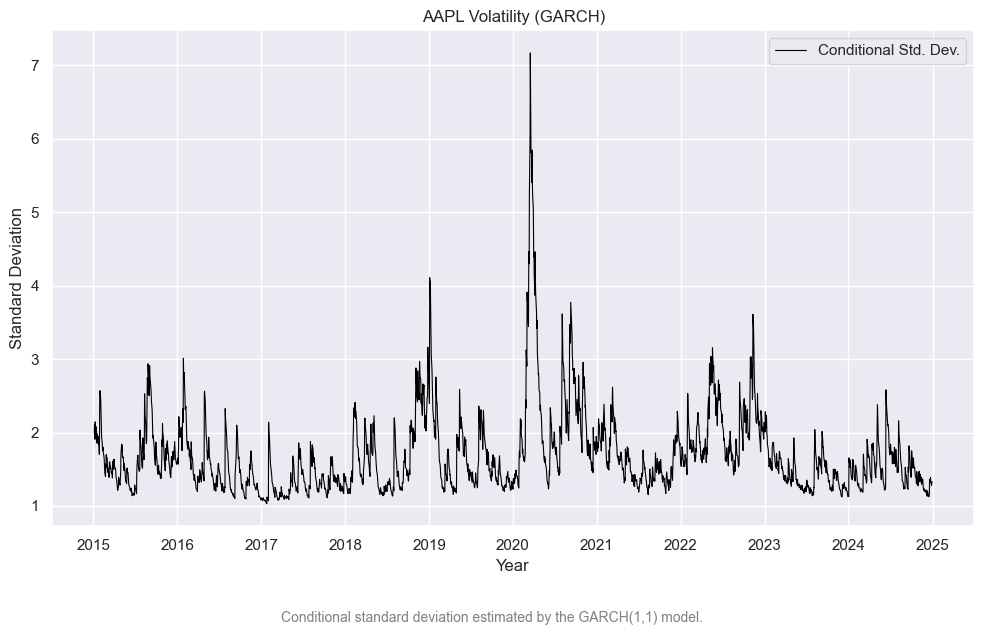

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from arch import arch_model

def plot_garch_volatility(garch_results, dates, title="Conditional Standard Deviation"):
    sigma = garch_results.conditional_volatility

    plt.figure(figsize=(10, 6))
    plt.plot(dates[-len(sigma):], sigma, color="black", linewidth=0.8, label='Conditional Std. Dev.')

    # Format x-axis to show year ticks
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())               # One tick per year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))       # Format as 'YYYY'

    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Standard Deviation")
    plt.legend()
    plt.tight_layout()
    plt.figtext(0.5, -0.05, 
                "Conditional standard deviation estimated by the GARCH(1,1) model.",
                wrap=True, horizontalalignment='center', fontsize=10, color="grey")
    plt.show()

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

aapl_data = df[df['symbol'] == 'AAPL'].copy()
aapl_data = aapl_data.set_index('date')
returns = 100 * np.log(aapl_data['adjusted'] / aapl_data['adjusted'].shift(1)).dropna()

# Fit GARCH model
model = arch_model(returns, vol='Garch', p=1, q=1, mean='constant')
garch_results = model.fit(disp='off')

# Plot
plot_garch_volatility(garch_results, returns.index, title="AAPL Volatility (GARCH)")


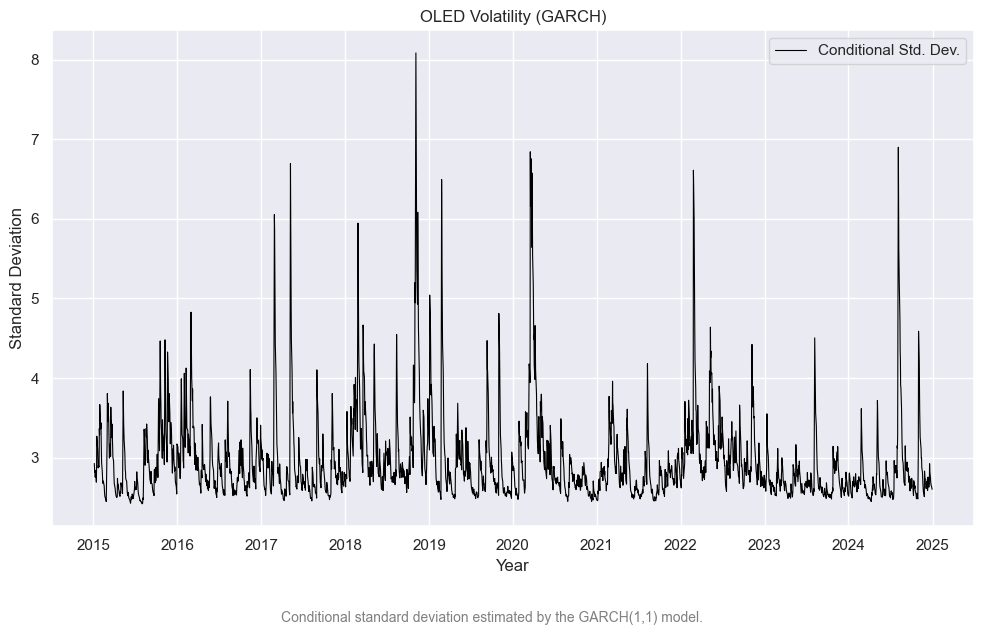

In [16]:
oled_data = df[df['symbol'] == 'OLED'].copy()
oled_data = oled_data.set_index('date')
returns = 100 * np.log(oled_data['adjusted'] / oled_data['adjusted'].shift(1)).dropna()

# Fit GARCH model
model = arch_model(returns, vol='Garch', p=1, q=1, mean='constant')
garch_results = model.fit(disp='off')

# Plot
plot_garch_volatility(garch_results, returns.index, title="OLED Volatility (GARCH)")

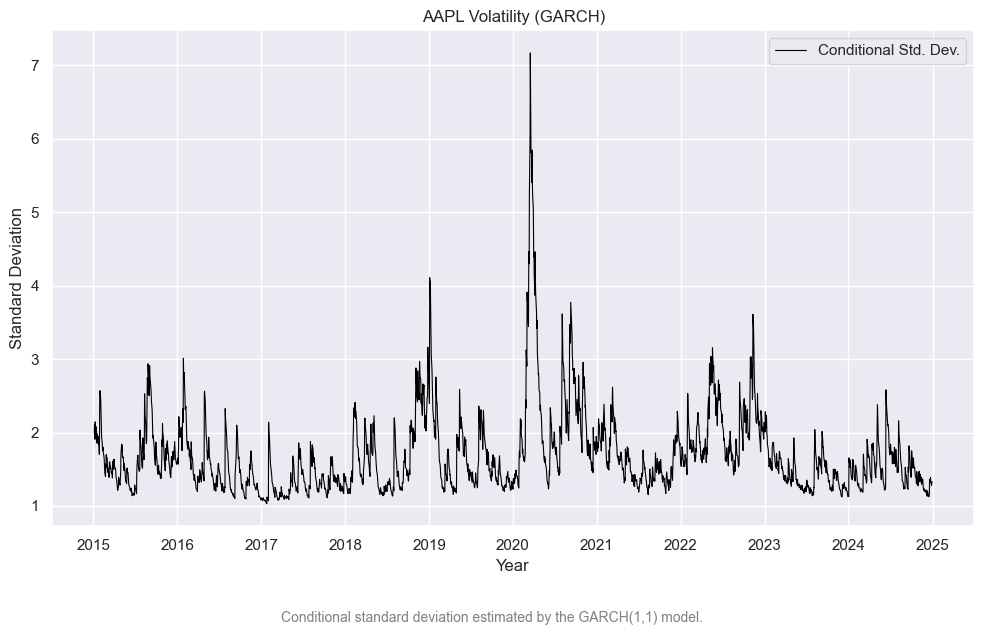

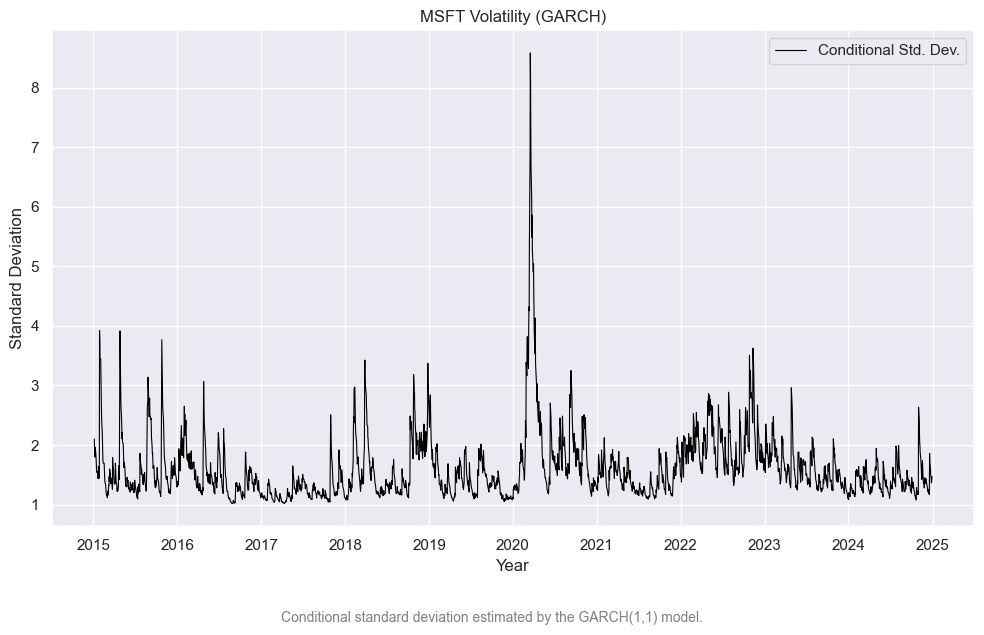

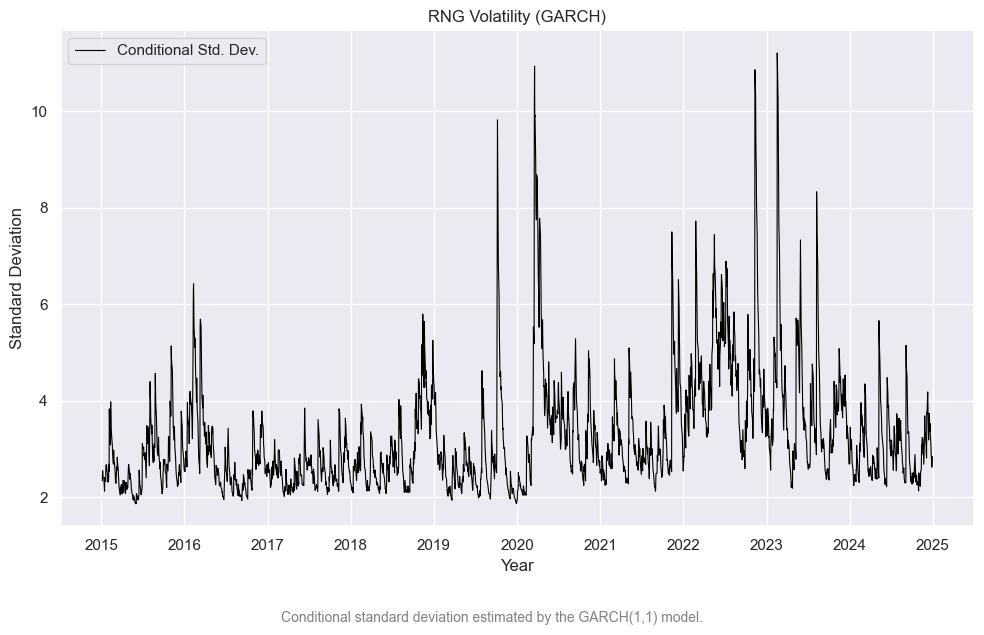

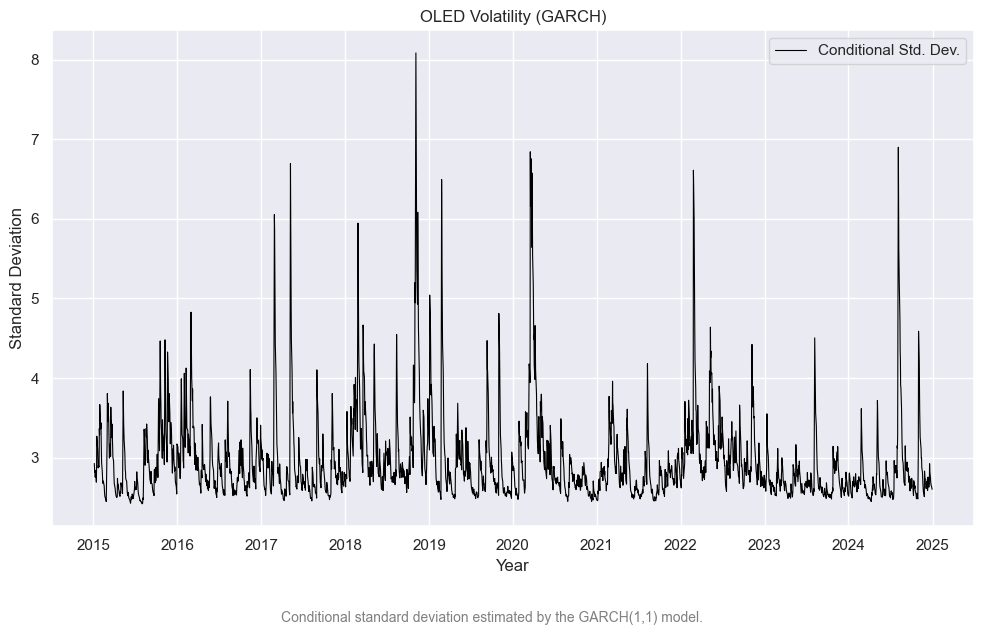

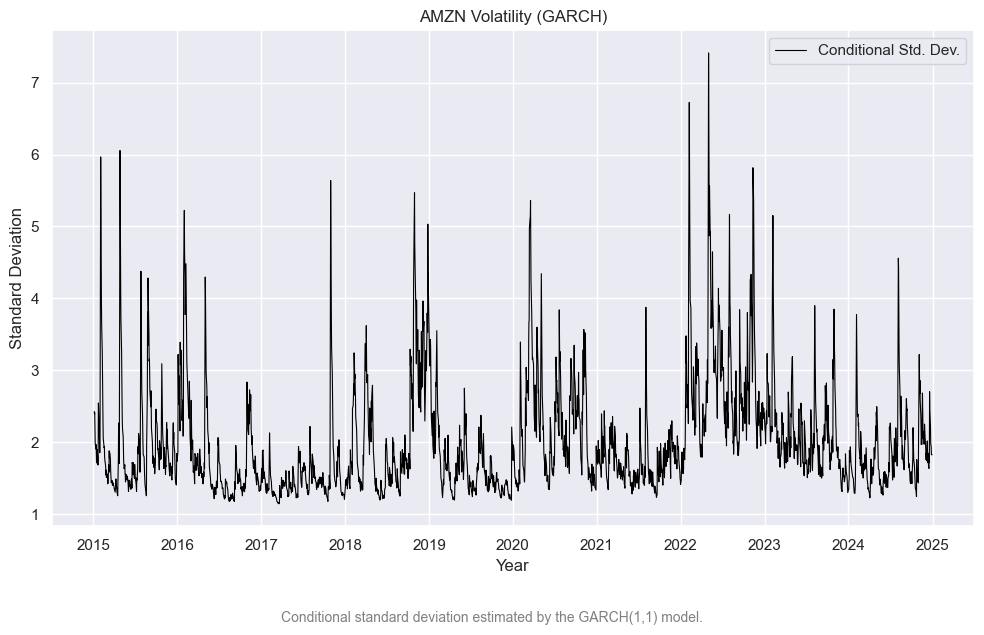

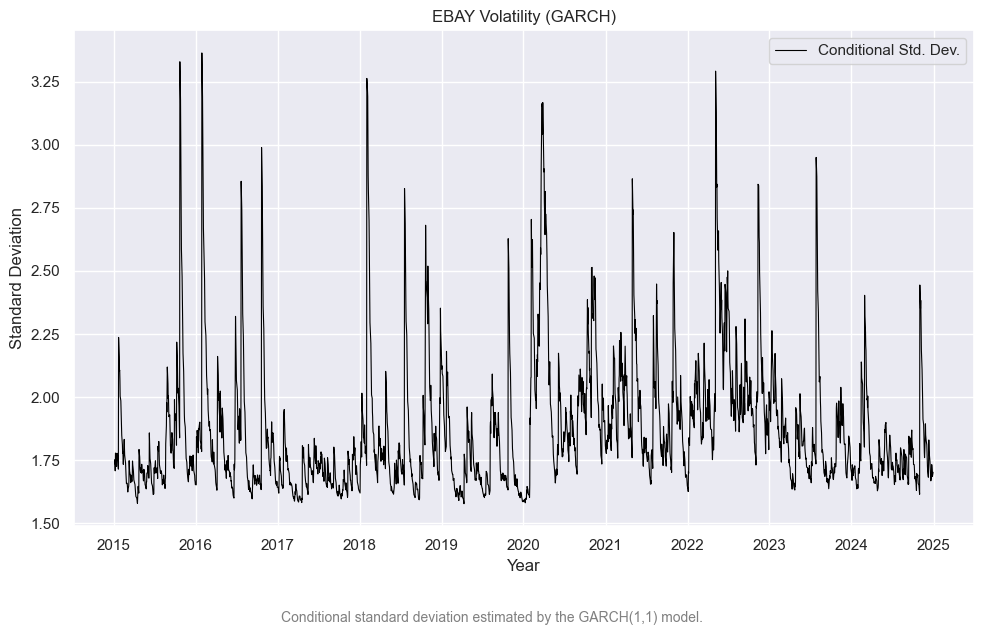

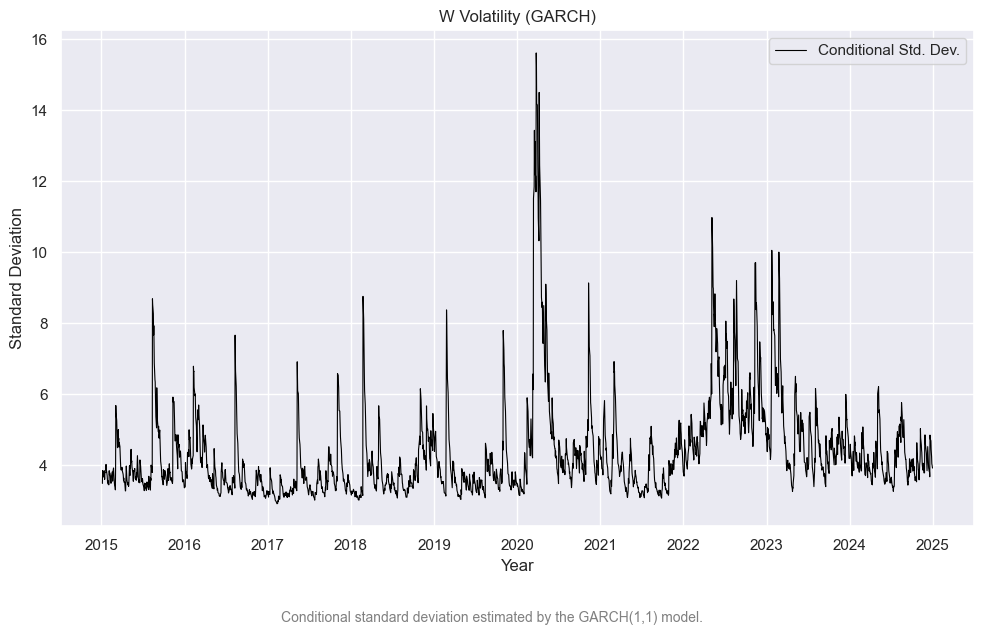

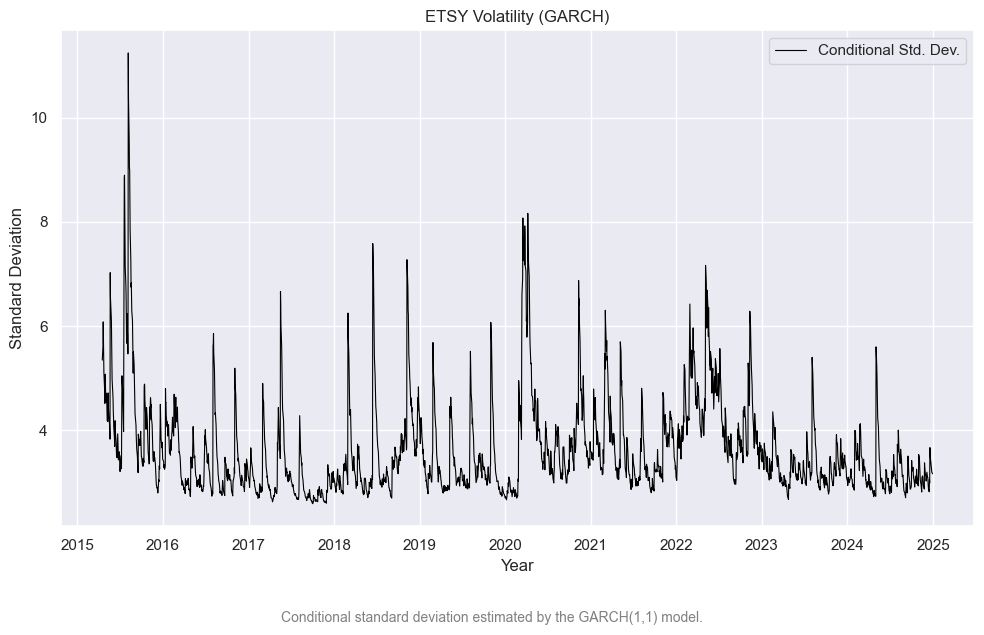

In [17]:

# List of tickers to process
tickers = ['AAPL', 'MSFT', 'RNG', 'OLED', 'AMZN', 'EBAY', 'W', 'ETSY']

# Loop over tickers
for ticker in tickers:
    company_data = df[df['symbol'] == ticker].copy()
    company_data = company_data.set_index('date').sort_index()
    returns = 100 * np.log(company_data['adjusted'] / company_data['adjusted'].shift(1)).dropna()

    try:
        model = arch_model(returns, vol='Garch', p=1, q=1, mean='constant')
        garch_results = model.fit(disp='off')
        plot_garch_volatility(garch_results, returns.index, title=f"{ticker} Volatility (GARCH)")
    except Exception as e:
        print(f"Could not fit GARCH model for {ticker}: {e}")

In [18]:
volatility_summary = []

for ticker in tickers:
    company_data = df[df['symbol'] == ticker].copy()
    company_data = company_data.set_index('date').sort_index()
    returns = 100 * np.log(company_data['adjusted'] / company_data['adjusted'].shift(1)).dropna()

    try:
        model = arch_model(returns, vol='Garch', p=1, q=1, mean='constant')
        garch_results = model.fit(disp='off')
        sigma = garch_results.conditional_volatility
        avg_vol = sigma.mean()  # Average conditional volatility
        volatility_summary.append({'Ticker': ticker, 'AverageVolatility': avg_vol})
    except Exception as e:
        print(f"Could not fit GARCH for {ticker}: {e}")

# Convert to DataFrame
vol_df = pd.DataFrame(volatility_summary)

# Add grouping info
vol_df['Cap'] = vol_df['Ticker'].map({
    'AAPL': 'Large Cap', 'MSFT': 'Large Cap',
    'RNG': 'Mid Cap', 'OLED': 'Mid Cap',
    'AMZN': 'Large Cap', 'EBAY': 'Large Cap',
    'W': 'Mid Cap', 'ETSY': 'Mid Cap'
})
vol_df['Industry'] = vol_df['Ticker'].map({
    'AAPL': 'Software', 'MSFT': 'Software',
    'RNG': 'Software', 'OLED': 'Software',
    'AMZN': 'E-commerce', 'EBAY': 'E-commerce',
    'W': 'E-commerce', 'ETSY': 'E-commerce'
})

# Compare by Cap
print(vol_df.groupby('Cap')['AverageVolatility'].mean())

# Compare by Industry
print(vol_df.groupby('Industry')['AverageVolatility'].mean())


Cap
Large Cap    1.793840
Mid Cap      3.548452
Name: AverageVolatility, dtype: float64
Industry
E-commerce    2.966226
Software      2.376067
Name: AverageVolatility, dtype: float64


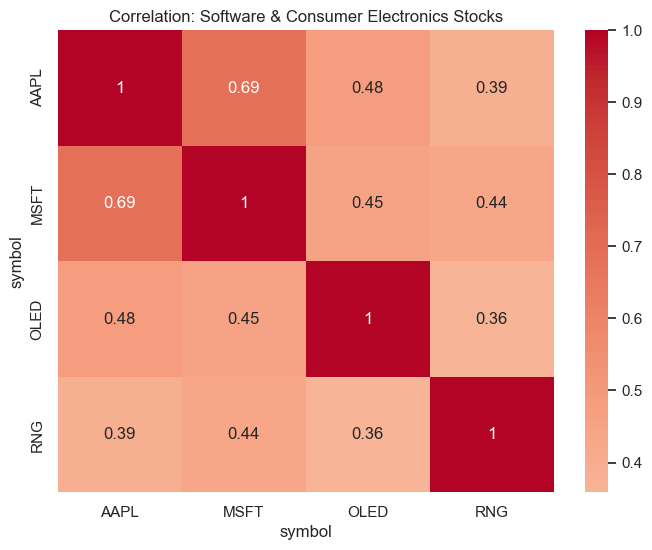

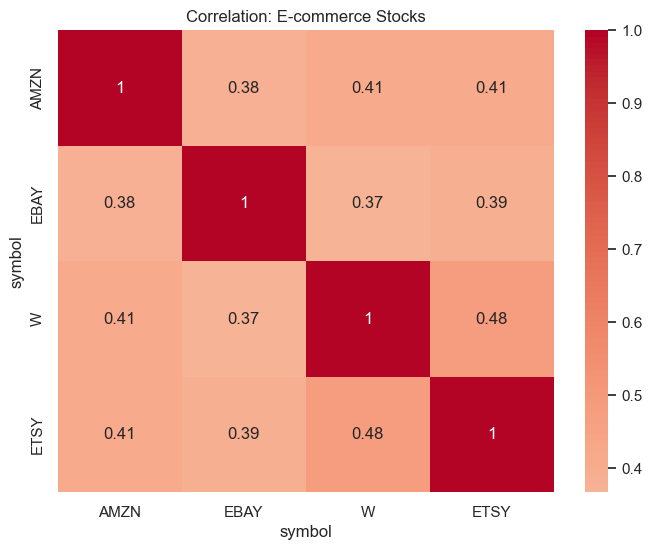

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df['log_return'] = np.log(df.groupby('symbol')['adjusted'].pct_change() + 1)

# Pivot to wide format: index = date, columns = symbol, values = log_return
returns = df.reset_index().pivot(index='date', columns='symbol', values='log_return')



# Define industry groups
software_ce = ['AAPL', 'MSFT', 'OLED', 'RNG']
ecommerce = ['AMZN', 'EBAY', 'W', 'ETSY']

# Filter to those symbols (some might be missing)
software_ce_present = [s for s in software_ce if s in returns.columns]
ecommerce_present = [s for s in ecommerce if s in returns.columns]

# Compute correlation matrices
corr_software_ce = returns[software_ce_present].corr()
corr_ecommerce = returns[ecommerce_present].corr()

# Plot Software & Consumer Electronics
plt.figure(figsize=(8, 6))
sns.heatmap(corr_software_ce, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation: Software & Consumer Electronics Stocks")
plt.show()

# Plot E-commerce
plt.figure(figsize=(8, 6))
sns.heatmap(corr_ecommerce, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation: E-commerce Stocks")
plt.show()


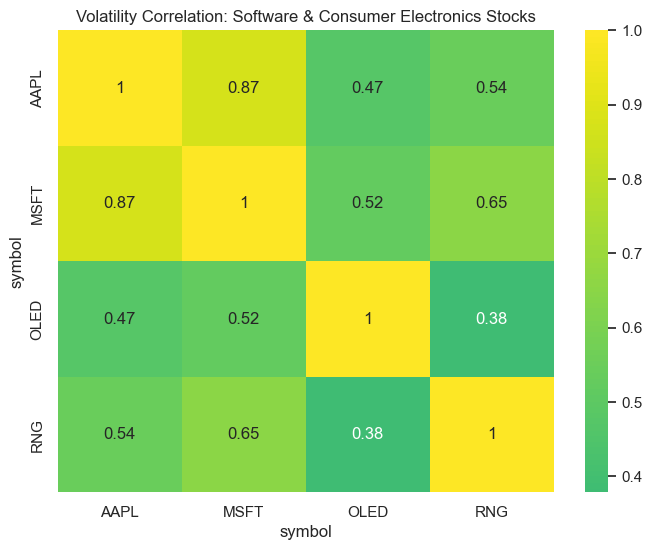

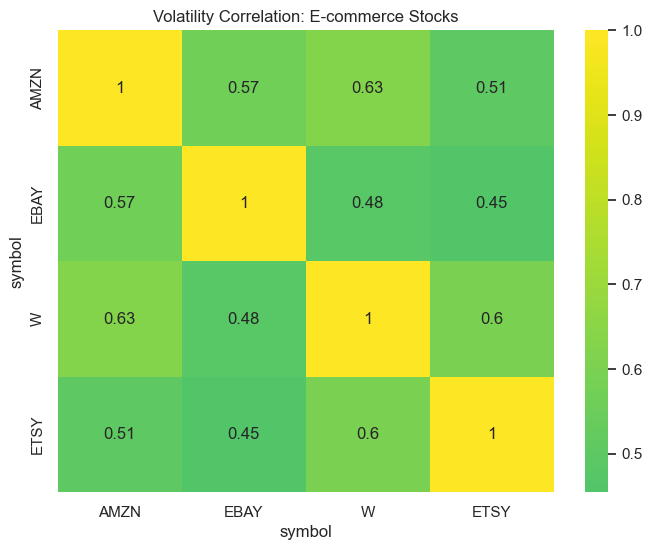

In [21]:
# Compute rolling volatility (e.g., 21-day std dev) for each stock
rolling_vol = returns.rolling(window=21).std()  # approx. 1 month

# Drop early NaNs from rolling window
rolling_vol = rolling_vol.dropna()

# Filter by industry
vol_software_ce = rolling_vol[software_ce_present]
vol_ecommerce = rolling_vol[ecommerce_present]

# Compute correlation matrices of volatility
corr_vol_software_ce = vol_software_ce.corr()
corr_vol_ecommerce = vol_ecommerce.corr()

# Plot Software & Consumer Electronics Volatility Correlation
plt.figure(figsize=(8, 6))
sns.heatmap(corr_vol_software_ce, annot=True, cmap='viridis', center=0)
plt.title("Volatility Correlation: Software & Consumer Electronics Stocks")
plt.show()

# Plot E-commerce Volatility Correlation
plt.figure(figsize=(8, 6))
sns.heatmap(corr_vol_ecommerce, annot=True, cmap='viridis', center=0)
plt.title("Volatility Correlation: E-commerce Stocks")
plt.show()


📊 Correlation between Factor Exposures (across stocks):
          Mkt_RF       SMB       HML       RMW       CMA
Mkt_RF  1.000000  0.629666 -0.554641 -0.177449 -0.357177
SMB     0.629666  1.000000 -0.806907 -0.675922 -0.380170
HML    -0.554641 -0.806907  1.000000  0.750783  0.512356
RMW    -0.177449 -0.675922  0.750783  1.000000  0.629761
CMA    -0.357177 -0.380170  0.512356  0.629761  1.000000


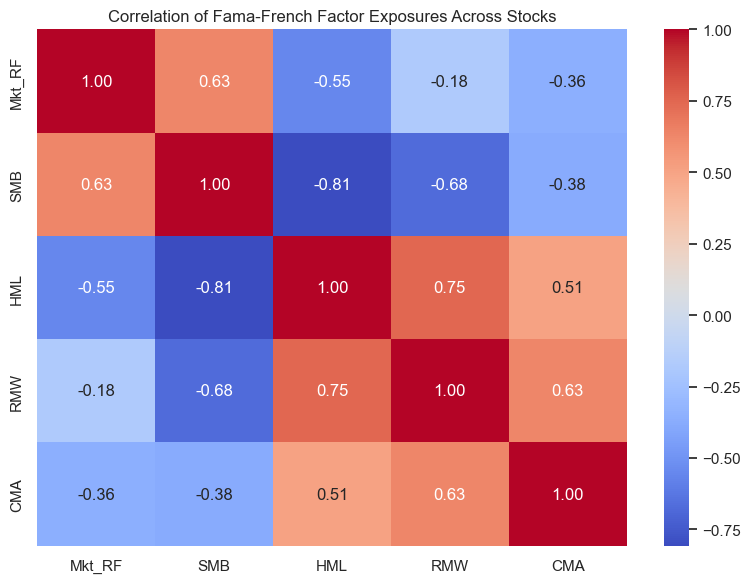

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming summary_df contains: rows = stocks, columns = factor exposures
# (e.g., Mkt_RF, SMB, HML, RMW, CMA) — Alpha optional

# Step 1: Compute correlation between factor exposures
exposure_corr = summary_df.corr()

# Step 2: Display correlation matrix
print("📊 Correlation between Factor Exposures (across stocks):")
print(exposure_corr)

# Step 3: Optional — visualize with a heatmap
plt.figure(figsize=(8,6))
sns.heatmap(exposure_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Fama-French Factor Exposures Across Stocks")
plt.tight_layout()
plt.show()


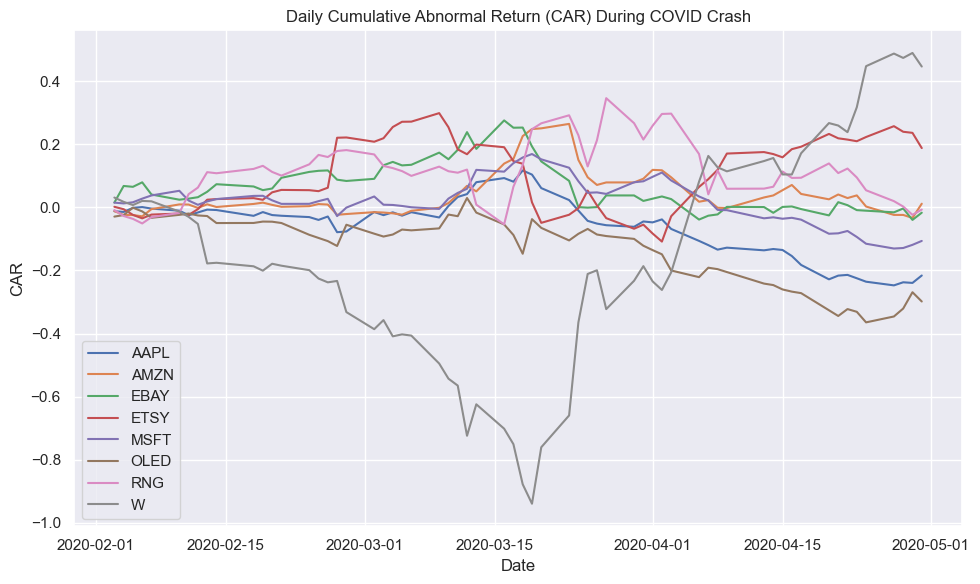

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'date' is datetime
df['date'] = pd.to_datetime(df['date'])

# Sort data properly
df = df.sort_values(['symbol', 'date'])

# Step 1: Calculate daily returns by symbol
df['return'] = df.groupby('symbol')['adjusted'].pct_change()

# Step 2: Compute benchmark return (cross-sectional average of returns per date)
benchmark = df.groupby('date')['return'].mean().reset_index()
benchmark.rename(columns={'return': 'benchmark_return'}, inplace=True)

# Step 3: Merge benchmark return back to original df
df = df.merge(benchmark, on='date', how='left')

# Step 4: Calculate abnormal return
df['abnormal_return'] = df['return'] - df['benchmark_return']

# Step 5: Filter to COVID crash period (adjust dates if needed)
covid_df = df[(df['date'] >= '2020-02-01') & (df['date'] <= '2020-04-30')].copy()

# Step 6: Calculate daily cumulative abnormal return (CAR)
covid_df['CAR'] = covid_df.groupby('symbol')['abnormal_return'].cumsum()

# Step 7: Plot CAR line chart by symbol
plt.figure(figsize=(10, 6))
for symbol in covid_df['symbol'].unique():
    subset = covid_df[covid_df['symbol'] == symbol]
    plt.plot(subset['date'], subset['CAR'], label=symbol)

plt.title('Daily Cumulative Abnormal Return (CAR) During COVID Crash')
plt.xlabel('Date')
plt.ylabel('CAR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
